In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# # set fonts configuration - Arial
# matplotlib.rcParams['font.family'] = "Open Sans"
# matplotlib.rcParams['font.sans-serif'] = "Arial"

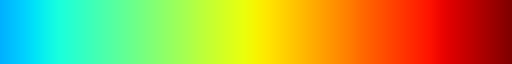

In [306]:
colors1 = plt.cm.Greys_r(np.linspace(0.5, 1, 10))
#colors2 = plt.cm.jet(np.linspace(0.3, 1, 45))

# combine them and build a new colormap
colors = np.vstack((colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

#### MCS duration statistics (2001-2020)

In [5]:
# %%time
# year_list = np.arange(2001,2021)

# for n, year in enumerate(year_list):
#     #print('processing year: {}'.format(year))
#     dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
#     data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
#     if n == 0:
#         mcs_duration_all = data_track.mcs_duration.values
#     else:
#         tmp = data_track.mcs_duration.values
#         mcs_duration_all = np.concatenate([mcs_duration_all, tmp])    

In [6]:
# fig, ax = plt.subplots(1,1,figsize=(4.5,4))

# ax.hist(mcs_duration_all, bins=30, range=(0,60), edgecolor="red", align='left',facecolor='lightgrey')
# ax.set_xticks(np.arange(0,64,4))
# ax.set_ylabel('Number', fontsize=10.5)
# ax.set_xlabel('MSC duration (hr)', fontsize=10.5);
# ax.set_title('Tracked MCS duration \n (Tropics, 30S-30N, 2001-2020)', fontweight='bold'
#              ,fontsize=10, x=0.65, y=0.8, color='dimgrey')
# #ax.set_yticks(np.arange(0,5500,500));
# ax.grid(axis='y', linestyle=':', linewidth=0.5)

#### daily mean + tracks initialized at the first hour

In [186]:
BL_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae')
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/2014')
data_temp = xr.open_dataset(BL_dir / 'era5_2layers_thetae_2014_07_15.nc').sel(lat=slice(-30,30))
lon_re = data_temp.lon
lat_re = data_temp.lat
counts_map = np.zeros((len(year_list), 12, len(lat_re), len(lon_re)))

# read file as mfdataset
data_sp = xr.open_dataset(era5_dir / 'era-5.sp.2014.07.nc').sel(latitude=slice(30,-30)).SP/100 # hPa
data_sp = data_sp.reindex(latitude=sorted(list(data_sp.latitude))) # fliping latitude order: -30 to 30
data_sp = data_sp.interp(latitude=lat_re.values, longitude=lon_re.values)
data_sp = data_sp.rename({'latitude': 'lat', 'longitude': 'lon'})

# 3-hourly buoyancy data on the day
files_theta = 'era5_2layers_thetae_2014_07_15.nc'
data = xr.open_dataset(BL_dir / files_theta).sel(lat=slice(-30,30))
sp = data_sp.sel(time=data.time)

thetae_bl = data.thetae_bl
thetae_sat_lt = data.thetae_sat_lt
thetae_lt = data.thetae_lt

delta_pl=sp-100-500 # top at 500hPa
delta_pb=100
wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
wl=1-wb

# calculate buoyancy estimate
Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT # degree Kelvin (K)

In [191]:
# get GPM-IMERG daily mean
dir_gpm = Path('/neelin2020/RGMA_feature_mask/GPM_ncfiles_2014')
files = sorted(list(dir_gpm.glob('GPM_IMERGE_V06_20140715_*.nc')))
data_gpm = xr.open_mfdataset(files)
prec_gpm_daily = data_gpm.precipitationCal.mean('time').sel(lat=slice(-30,30))

In [224]:
%%time
# track with MCS initialized during that day
dir_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/')
data_track = xr.open_dataset(dir_track / 'mcs_tracks_final_extc_20140101.0000_20150101.0000.nc')
meanlat = data_track.isel(times=0).meanlat
idx_trop = np.where(abs(meanlat < 30))[0]
data_track = data_track.isel(tracks=idx_trop)

idx_select = []
for track in data_track.tracks:
    data_track_sub = data_track.sel(tracks=track)
    #idt_mcs_init = data_track_sub.idt_mcs_init.values
    timestamp = str(data_track_sub.isel(times=0).base_time.values)
    month = timestamp[5:7]
    day = timestamp[8:10]
    if (month == '07') and (day == '15'):
        idx_select.extend([track])
        
data_track_day = data_track.sel(tracks=idx_select)

CPU times: user 1min 55s, sys: 1.08 s, total: 1min 57s
Wall time: 1min 57s


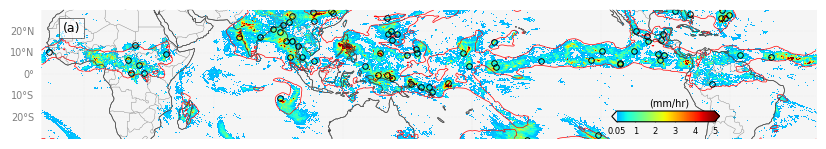

In [344]:
# plotting tracks on 2014-07-01 and BL

fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree(160)})

ax.coastlines(color='k',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.spines[:].set_visible(False)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=0.1, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 7, 'color': 'grey'}
gl.ylabel_style = {'size': 7, 'color': 'grey'}

# plot daily mean of BL_TOT as background

cf = ax.contour(Buoy_TOT.lon, Buoy_TOT.lat, -Buoy_TOT.mean('time'), ls='--', levels=[5], linewidths=0.5,
          colors='r', transform=ccrs.PlateCarree(), zorder=2)

# plot daily mean of GPM-IMERG 
cp = ax.pcolormesh(prec_gpm_daily.lon, prec_gpm_daily.lat, prec_gpm_daily.T,
           cmap=mixedmap, vmin=0.05, vmax=5, transform=ccrs.PlateCarree())
cp.cmap.set_under('whitesmoke')

# insert colorbar inside the figure
cax = ax.inset_axes([85, -22, 50, 5], transform=ax.transData)
cax.set_facecolor('w')
cbar = plt.colorbar(cp, cax=cax, orientation='horizontal', extend='both')
cbar.set_ticks([0.05,1,2,3,4,5])
cbar.set_ticklabels([0.05,1,2,3,4,5])
cbar.ax.tick_params(labelsize=6, length=0.2)
ax.text(x=102.5, y=-15, s='(mm/hr)', fontsize=7)

# plot tracks
for track in data_track_day.tracks:
    
    data_track_sub = data_track_day.sel(tracks=track)
    
    lon_traject = []
    lat_traject = []
    mcs_status = data_track_sub.mcs_status
    idt_mcs_init = np.where(mcs_status)[0][0]
    
    meanlon = data_track_sub.isel(times=idt_mcs_init).meanlon
    meanlat = data_track_sub.isel(times=idt_mcs_init).meanlat
    lon_traject.extend([meanlon])
    lat_traject.extend([meanlat])
    
    ax.plot(lon_traject, lat_traject, color='k', marker='o', ms=4, markeredgewidth=0.7, markerfacecolor='None'
                ,alpha=1, transform=ccrs.PlateCarree(),zorder=3) # set edgecolor none to show arrows only
    
ax.set_ylim([-30,30])
ax.text(x=-170, y=20, s='(a)', fontsize=9,
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5, lw=0.5))
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig1_globalmap_exampleday.pdf',
   bbox_inches='tight', transparent=False)

In [113]:
# exmaple map of tracked MCSs
year = 2014
dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
dir_BL = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats/')

# tracks during JJA, 2014
data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
track_JJA = []
for track in data_track.tracks.values:
    month_track = pd.to_datetime(data_track.sel(tracks=track).base_time[0].values).month
    if (month_track == 6) or (month_track == 7) or (month_track == 8):
        track_JJA.extend([track])
        
# tracks during DJF, 2014
data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
track_DJF = []
for track in data_track.tracks.values:
    month_track = pd.to_datetime(data_track.sel(tracks=track).base_time[0].values).month
    if (month_track == 12) or (month_track == 1) or (month_track == 2):
        track_DJF.extend([track])
        
track_June = []
for track in data_track.tracks.values:
    month_track = pd.to_datetime(data_track.sel(tracks=track).base_time[0].values).month
    if (month_track == 6):
        track_June.extend([track])
        
# BL seasonal mean of JJA and DJF in 2014
BL_JJA = xr.open_dataset(dir_BL / 'era5_BL_measures_monthly_avg.2002-2014.nc').sel(year=year, month=[6,7,8]).mean('month')
BL_DJF = xr.open_dataset(dir_BL / 'era5_BL_measures_monthly_avg.2002-2014.nc').sel(year=year, month=[12,1,2]).mean('month')
BL_June = xr.open_dataset(dir_BL / 'era5_BL_measures_monthly_avg.2002-2014.nc').sel(year=year, month=[6]).mean('month')

CPU times: user 6.2 s, sys: 142 ms, total: 6.34 s
Wall time: 6.14 s


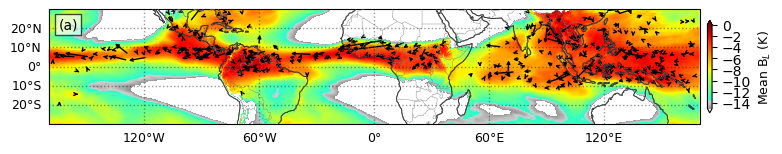

In [116]:
%%time
### vector map of MCSs
fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot monthly mean of BL_TOT as background
cf = ax.pcolormesh(BL_June.lon, BL_June.lat, 340*3/9.8*BL_June.Buoy_TOT, vmin=-15, vmax=0,
           cmap=mixedmap, transform=ccrs.PlateCarree())
cf.cmap.set_under('w')
cbar = plt.colorbar(cf, ax=ax, shrink=0.4, pad=0.01, extend='both')
cbar.set_label('Mean B$_{L}$ (K)',fontsize=9)
cbar.set_ticks([-14,-12,-10,-8,-6,-4,-2,0])
# reference at -10K
#ax.contour(BL_JJA.lon, BL_JJA.lat, 340*3/9.8*BL_June.Buoy_TOT, levels=[-10],
#          colors=['k'], linewidths=1, transform=ccrs.PlateCarree())

# plotting section of JJA tracks in 2014
for track in track_June:
    
    data_track_sub = data_track.sel(tracks=track)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]
    duration = data_track_sub.mcs_duration
    
    # edgecolor as duration indicator
    if duration < 12:
        ccolor = 'k'
    elif ( duration >= 12 ) and ( duration < 24 ):
        ccolor = 'k'
    else:
        ccolor = 'k'
    
    lon_traject = []
    lat_traject = []
    position_arrow = []
    for idt in [idt_phase[0],idt_phase[4]]: # initial and ending phase 
    
        meanlon = data_track_sub.isel(times=idt).meanlon
        meanlat = data_track_sub.isel(times=idt).meanlat
        # plot geolocation on the map
        ax.plot(meanlon, meanlat, color='None', marker='o', markerfacecolor='None', alpha=0.5
                , transform=ccrs.PlateCarree()); # set edgecolor none to show arrows only
        lon_traject.extend([meanlon])
        lat_traject.extend([meanlat])
        position_arrow.append((meanlon, meanlat))
    
    # plotting arrow between markers at Init and End
    for n in range(len(position_arrow)-1):
        arrow = FancyArrowPatch(posA=position_arrow[n], posB=position_arrow[n+1],
                                        arrowstyle='->', mutation_scale=5, color=ccolor)
        ax.add_patch(arrow)
                
#ax.set_title('Geolocation of Tropical MCSs, JJA, 2014', fontsize=10);
ax.set_ylim([-30,30])
ax.set_xlim([-170,170])

ax.text(-165, 20, '(a)', color='k', 
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5));

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/non2MCSs_trajectory_BL_2014JJA.pdf', bbox_inches='tight',
#         transparent=False)

CPU times: user 38.3 s, sys: 446 ms, total: 38.8 s
Wall time: 38.2 s


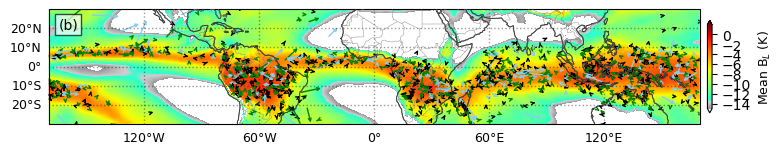

In [93]:
%%time
### vector map of MCSs
fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot seasonal mean of BL_TOT as background
cf = ax.pcolormesh(BL_DJF.lon, BL_DJF.lat, 340*3/9.8*BL_DJF.Buoy_TOT, vmin=-15, vmax=2,
           cmap=mixedmap, transform=ccrs.PlateCarree())
cf.cmap.set_under('w')
cbar = plt.colorbar(cf, ax=ax, shrink=0.4, pad=0.01, extend='both')
cbar.set_label('Mean B$_{L}$ (K)',fontsize=9)
cbar.set_ticks([-14,-12,-10,-8,-6,-4,-2,0])
# reference at -10K
ax.contour(BL_DJF.lon, BL_DJF.lat, 340*3/9.8*BL_DJF.Buoy_TOT, levels=[-10],
          colors=['k'], linewidths=1, transform=ccrs.PlateCarree())

# plotting section of JJA tracks in 2014
for track in track_DJF:
    
    data_track_sub = data_track.sel(tracks=track)
    idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                 data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                 data_track_sub.idt_mcs_end]
    duration = data_track_sub.mcs_duration
    
    # edgecolor as duration indicator
    if duration < 12:
        ccolor = 'k'
    elif ( duration >= 12 ) and ( duration < 24 ):
        ccolor = 'g'
    else:
        ccolor = 'skyblue'
    
    lon_traject = []
    lat_traject = []
    position_arrow = []
    for idt in [idt_phase[0],idt_phase[4]]: # initial and ending phase 
    
        meanlon = data_track_sub.isel(times=idt).meanlon
        meanlat = data_track_sub.isel(times=idt).meanlat
        # plot geolocation on the map
        ax.plot(meanlon, meanlat, color='None', marker='o', markerfacecolor='None', alpha=0.5
                , transform=ccrs.PlateCarree()); # set edgecolor none to show arrows only
        lon_traject.extend([meanlon])
        lat_traject.extend([meanlat])
        position_arrow.append((meanlon, meanlat))
    
    # plotting arrow between markers at Init and End
    for n in range(len(position_arrow)-1):
        arrow = FancyArrowPatch(posA=position_arrow[n], posB=position_arrow[n+1],
                                        arrowstyle='->', mutation_scale=5, color=ccolor)
        ax.add_patch(arrow)
                
#ax.set_title('Geolocation of Tropical MCSs, DJF, 2014', fontsize=10);
ax.set_ylim([-30,30])
ax.set_xlim([-170,170])

ax.text(-165, 20, '(b)', color='k', 
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5));

fig.savefig('/scratch/wmtsai/temp_mcs/fig/non2MCSs_trajectory_BL_2014DJF.pdf', bbox_inches='tight',
          transparent=False)

#### frequency of tropical MCSs (non2MCS tracks)

In [82]:
%%time
# multiyear all tracks (2015-2018)

year_list = np.arange(2001,2021)

dx = 2
lon_bins = np.arange(-180,180,dx)
lat_bins = np.arange(-30,30+dx,dx)
freq_map = np.zeros((3, len(lat_bins)-1, len(lon_bins)-1))

for year in year_list:
    
    print('processing year : {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    print('MCS tracks: {}'.format(len(data_track.tracks)))
    for track in data_track.tracks.values:
    
        data_track_sub = data_track.sel(tracks=track)
        #idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
        #            data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
        #            data_track_sub.idt_mcs_end]
        idt_phase = [data_track_sub.idt_mcs_init]
        duration = data_track_sub.mcs_duration
        
        for idt in idt_phase: # locations in all phases are considered
            meanlon = data_track_sub.isel(times=idt).meanlon.values
            meanlat = data_track_sub.isel(times=idt).meanlat.values

            idx_lon = np.argmin(abs(meanlon-lon_bins))-1
            idx_lat = np.argmin(abs(meanlat-lat_bins))-1
            
            if duration < 12:
                freq_map[0, idx_lat, idx_lon] += 1
            elif (duration >= 12) and (duration < 24):
                freq_map[1, idx_lat, idx_lon] += 1
            else:
                freq_map[2, idx_lat, idx_lon] += 1
                
# writeout as xarray dataset
ds = xr.Dataset(data_vars=dict(frequency=(['duration_type','lat','lon'], freq_map)),
                coords=dict(duration_type=(['duration_type'],['S','M','L']),
                            lat=(['lat'],lat_bins[:-1]),
                            lon=(['lon'],lon_bins[:-1])))

In [109]:
%%time
#### All tracks without filtering 

year_list = np.arange(2001,2021)

dx = 2
lon_bins = np.arange(-180,180,dx)
lat_bins = np.arange(-30,30+dx,dx)
freq_map = np.zeros((3, len(lat_bins)-1, len(lon_bins)-1))

for year in year_list:
    
    print('processing year : {}'.format(year))
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_final_extc_{}0101.0000_{}0101.0000.nc'.format(year,year+1))
    
    lat_info = data_track.isel(times=0).meanlat
    idx_30deg = np.where(abs(lat_info) < 30)[0]
    data_track = data_track.isel(tracks=idx_30deg) # tropical tracks
    
    print('MCS tracks: {}'.format(len(data_track.tracks)))
    for track in data_track.tracks.values:
    
        data_track_sub = data_track.sel(tracks=track)
        duration = data_track_sub.mcs_duration
        
        meanlon = data_track_sub.isel(times=0).meanlon.values
        meanlat = data_track_sub.isel(times=0).meanlat.values

        idx_lon = np.argmin(abs(meanlon-lon_bins))-1
        idx_lat = np.argmin(abs(meanlat-lat_bins))-1

        if duration < 12:
            freq_map[0, idx_lat, idx_lon] += 1
        elif (duration >= 12) and (duration < 24):
            freq_map[1, idx_lat, idx_lon] += 1
        else:
            freq_map[2, idx_lat, idx_lon] += 1
                
# writeout as xarray dataset
ds = xr.Dataset(data_vars=dict(frequency=(['duration_type','lat','lon'], freq_map)),
                coords=dict(duration_type=(['duration_type'],['S','M','L']),
                            lat=(['lat'],lat_bins[:-1]),
                            lon=(['lon'],lon_bins[:-1])))

processing year : 2001
MCS tracks: 29129
processing year : 2002
MCS tracks: 27245
processing year : 2003
MCS tracks: 28183
processing year : 2004
MCS tracks: 28858
processing year : 2005
MCS tracks: 27885
processing year : 2006
MCS tracks: 28138
processing year : 2007
MCS tracks: 28938
processing year : 2008
MCS tracks: 29454
processing year : 2009
MCS tracks: 28719
processing year : 2010
MCS tracks: 29041
processing year : 2011
MCS tracks: 28761
processing year : 2012
MCS tracks: 29245
processing year : 2013
MCS tracks: 28993
processing year : 2014
MCS tracks: 27740
processing year : 2015
MCS tracks: 26341
processing year : 2016
MCS tracks: 27613
processing year : 2017
MCS tracks: 26996
processing year : 2018
MCS tracks: 27544
processing year : 2019
MCS tracks: 26255
processing year : 2020
MCS tracks: 26226
CPU times: user 41min 33s, sys: 12.5 s, total: 41min 45s
Wall time: 41min 51s


In [110]:
ds.to_netcdf('/scratch/wmtsai/temp_mcs/output_stats/MCSfrequency_init_2x2deg_map.2001.2020.alltracks.nc')

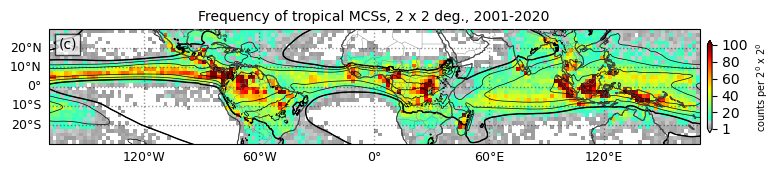

In [80]:
### vector map of MCSs
BL_clim = xr.open_dataset(dir_BL / 'era5_BL_measures_monthly_avg.2002-2014.nc').mean(('year','month'))

fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

freq_tot = ds.frequency.sum('duration_type')
freq_tot = freq_tot.where(freq_tot > 1)

# plot seasonal mean of BL_TOT as background
cf = ax.pcolormesh(ds.lon+1, ds.lat+1, freq_tot, vmin=1, vmax=100,
           cmap=mixedmap, transform=ccrs.PlateCarree())
cf.cmap.set_under('lightgrey')
cbar = plt.colorbar(cf, ax=ax, shrink=0.4, pad=0.01, extend='both')
cbar.set_label('counts per 2$^{0}$ x 2$^{0}$',fontsize=7)
cbar.set_ticks([1,20,40,60,80,100])

#cbar.set_ticks([10,50,100,150])
# BL climatology, flip negative sign for plotting solid contours
ax.contour(BL_clim.lon+1, BL_clim.lat+1, -340*3/9.8*BL_clim.Buoy_TOT, levels=[0,2,4,6,8,10],
          colors=['k'], linewidths=0.5, transform=ccrs.PlateCarree())
ax.contour(BL_clim.lon+1, BL_clim.lat+1, -340*3/9.8*BL_clim.Buoy_TOT, levels=[10],
          colors=['k'], linewidths=1, transform=ccrs.PlateCarree())
                
ax.set_title('Frequency of tropical MCSs, 2 x 2 deg., 2001-2020', fontsize=10);
ax.set_ylim([-30,30])
ax.set_xlim([-170,170])

ax.text(-165, 20, '(c)', color='k', 
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5));

fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSint_non2MCSs_frequency_2001.2020.pdf', bbox_inches='tight',
         transparent=False)

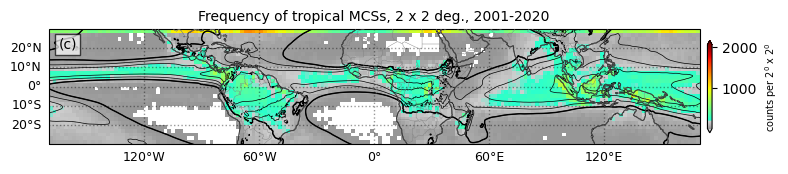

In [108]:
### vector map of MCSs
BL_clim = xr.open_dataset(dir_BL / 'era5_BL_measures_monthly_avg.2002-2014.nc').mean(('year','month'))
ds = xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/MCSfrequency_init_2x2deg_map.2001.2020.alltracks.nc')

fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

freq_tot = ds.frequency.sum('duration_type')
freq_tot = freq_tot.where(freq_tot > 1)

# plot seasonal mean of BL_TOT as background
cf = ax.pcolormesh(ds.lon+1, ds.lat+1, freq_tot, vmin=1,
           cmap=mixedmap, transform=ccrs.PlateCarree())
cf.cmap.set_under('lightgrey')
cbar = plt.colorbar(cf, ax=ax, shrink=0.4, pad=0.01, extend='both')
cbar.set_label('counts per 2$^{0}$ x 2$^{0}$',fontsize=7)
#cbar.set_ticks([1,20,40,60,80,100])

#cbar.set_ticks([10,50,100,150])
# BL climatology, flip negative sign for plotting solid contours
ax.contour(BL_clim.lon+1, BL_clim.lat+1, -340*3/9.8*BL_clim.Buoy_TOT, levels=[0,2,4,6,8,10],
          colors=['k'], linewidths=0.5, transform=ccrs.PlateCarree())
ax.contour(BL_clim.lon+1, BL_clim.lat+1, -340*3/9.8*BL_clim.Buoy_TOT, levels=[10],
          colors=['k'], linewidths=1, transform=ccrs.PlateCarree())
                
ax.set_title('Frequency of tropical MCSs, 2 x 2 deg., 2001-2020', fontsize=10);
ax.set_ylim([-30,30])
ax.set_xlim([-170,170])

ax.text(-165, 20, '(c)', color='k', 
        bbox=dict(facecolor='w', alpha=0.7, edgecolor='k', pad=2.5));

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSint_non2MCSs_frequency_2001.2020.pdf', bbox_inches='tight',
#         transparent=False)

In [ ]:
# climatology BL 
BL_clim = xr.open_dataset(dir_BL / 'era5_BL_measures_monthly_avg.2002-2014.nc').mean(('year','month'))

### vector map of MCSs
fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'k'}
gl.ylabel_style = {'size': 9, 'color': 'k'}

# plot seasonal mean of BL_TOT as background
cf = ax.pcolormesh(BL_clim.lon, BL_clim.lat, 340*3/9.8*BL_clim.Buoy_TOT, vmin=-15, vmax=2,
           cmap='jet', transform=ccrs.PlateCarree())
cf.cmap.set_under('lightgrey')
cbar = plt.colorbar(cf, ax=ax, shrink=0.4, pad=0.01, extend='both')
cbar.set_label('B$_{L}$ (K)',fontsize=9)
cbar.set_ticks([-14,-12,-10,-8,-6,-4,-2,0,2])
# reference at -10K
ax.contour(BL_clim.lon, BL_clim.lat, 340*3/9.8*BL_clim.Buoy_TOT, levels=[-10],
           colors=['m'], linewidths=1, transform=ccrs.PlateCarree())
                
ax.set_title('Buoyancy measure, Climatology', fontsize=10, fontweight='bold');
ax.set_ylim([-30,30])

#fig.savefig('/scratch/wmtsai/temp_mcs/fig/non2MCSs_trajectory_BL_climatologyBLonly.pdf', bbox_inches='tight',
#           transparent=False)

In [ ]:
%%time
# propagation distributions
# generate dataset [duration, distance]

year_list = np.arange(2010,2020)
dist_samples_SL = [] # short-lived
dist_samples_ML = [] # short-lived
dist_samples_LL = [] # short-lived

for year in year_list:
    
    dir_mcs_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))
    
    for track in data_track.tracks.values:

        data_track_sub = data_track.sel(tracks=track)
        mcs_duration = data_track_sub.mcs_duration.values

        idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_end]

        lon_traject = []
        lat_traject = []
        position_arrow = []
        for idt in idt_phase: # initial and ending phase 

            meanlon = data_track_sub.isel(times=idt).meanlon
            meanlat = data_track_sub.isel(times=idt).meanlat
            lon_traject.extend([meanlon])
            lat_traject.extend([meanlat])
            
        # calculate the propagating distance (km), 1-deg. ~ 100 km 
        dist_traject = 100*np.sqrt(np.abs(lon_traject[1]-lon_traject[0])**2 + 
                               np.abs(lat_traject[1]-lat_traject[0])**2)
        
        if mcs_duration < 12:
            dist_samples_SL.extend([dist_traject])
        elif (mcs_duration >= 12) and (mcs_duration < 24):
            dist_samples_ML.extend([dist_traject])
        elif (mcs_duration >= 24) and (mcs_duration < 72): 
            dist_samples_LL.extend([dist_traject])

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,3.5))

for n, (ax, samples,duration_type) in enumerate(zip([ax1,ax2,ax3],
                                     [dist_samples_SL, dist_samples_ML, dist_samples_LL],
                                     ['S','M','L'])):
    ax.hist(samples, bins=40, range=(25,2025), edgecolor='red',align='left',facecolor='lightgrey')
    ax.set_ylabel('Number',fontsize=10.5)
    ax.set_xlabel('Propagation distance (km)',fontsize=10.5)
    ax.set_xlim([0,2000])
    
    if n == 0:
        ax.set_title('Tracked MCS propagation (I->E) \n (Tropics, 30S-30N, 2010-2019)', fontweight='bold'
                 ,fontsize=10, x=0.6, y=0.8, color='dimgrey')

In [ ]:
%%time
# multiyear all tracks (2015-2018)
dx = 2.5
lon_bins = np.arange(-180,180+dx,dx)
lat_bins = np.arange(-30,30+dx,dx)
freq_map = np.zeros((3,len(lat_bins)-1, len(lon_bins)-1)) # < 12H, 12-24H, > 24H

for year in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:
    
    dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    
    for track in data_track.tracks.values:
    
        data_track_sub = data_track.sel(tracks=track)
        idt_phase = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_grow, 
                    data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_decay,
                    data_track_sub.idt_mcs_end]
        duration = data_track_sub.mcs_duration
        
        for idt in idt_phase: # only take geolocation of initialization
            #idt = data_track_sub.idt_mcs_init.values
            meanlon = data_track_sub.isel(times=idt).meanlon.values
            meanlat = data_track_sub.isel(times=idt).meanlat.values

            idx_lon = np.argmin(abs(meanlon-lon_bins))-1
            idx_lat = np.argmin(abs(meanlat-lat_bins))-1
            
            if duration < 12:
                freq_map[0, idx_lat, idx_lon] += 1
            elif (duration >= 12) and (duration < 24):
                freq_map[1, idx_lat, idx_lon] += 1
            else:
                freq_map[2, idx_lat, idx_lon] += 1
                
# writeout as xarray dataset
ds = xr.Dataset(data_vars=dict(frequency=(['duration_type','lat','lon'], freq_map)),
                coords=dict(duration_type=(['duration_type'],['S','M','L']),
                            lat=(['lat'],lat_bins[:-1]),
                            lon=(['lon'],lon_bins[:-1])))

In [ ]:
# # save freq_map to out_stats
# out_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
# ds.to_netcdf(out_dir / 'MCS_non2mcs_frequency_SMLduraton.nc')

In [ ]:
out_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
ds = xr.open_dataset(out_dir / 'MCS_non2mcs_frequency_SMLduraton.nc')

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,5.5),subplot_kw={'projection': ccrs.PlateCarree()})

for (ax, d_type, d_string) in zip([ax1,ax2,ax3],['S','M','L'],['(< 12H)', '(12-24H)', '(> 24H)']):

    ax.coastlines(color='k',linewidth=0.7)
    ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
    ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
    ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

    ds_rm0 = ds.frequency.where(ds.frequency > 5)
    cp = ax.pcolormesh(ds_rm0.lon+1.25, ds_rm0.lat+1.25, ds_rm0.sel(duration_type=d_type), 
                        vmin=0, vmax=100, cmap=mixedmap)
    cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.01, extend="max")
    cp.cmap.set_over("darkred")
    cbar.set_label('Count',fontsize=8)
    cbar.set_ticks([0,25,50,75,100])
    # add the number of samples
    num_samples = int(ds.frequency.sel(duration_type=d_type).sum().values)
    ax.text(130,33,'samples: {}'.format(num_samples), fontsize=8)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='k', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k'}
    
    ax.set_title('MCS Duration Type: {} {}'.format(d_type, d_string), fontsize=10, fontweight='bold')

In [ ]:
out_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/output_stats')
ds = xr.open_dataset(out_dir / 'MCS_non2mcs_frequency_SMLduraton.nc')

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,5.5),subplot_kw={'projection': ccrs.PlateCarree()})

for (ax, d_type, d_string) in zip([ax1,ax2,ax3],['S','M','L'],['(< 12H)', '(12-24H)', '(> 24H)']):

    ax.coastlines(color='k',linewidth=0.7)
    ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
    ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
    ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

    ds_rm0 = ds.frequency.where(ds.frequency > 5)
    cp = ax.pcolormesh(ds_rm0.lon+1.25, ds_rm0.lat+1.25, ds_rm0.sel(duration_type=d_type)/ds_rm0.sum('duration_type'), 
                        vmin=0, vmax=0.6, cmap=mixedmap)
    cbar = plt.colorbar(cp, ax=ax, shrink=0.6, pad=0.01, extend="max")
    cp.cmap.set_over("darkred")
    cbar.set_label('Count',fontsize=8)
    cbar.set_ticks([0,0.25,0.5])
    # add the number of samples
    num_samples = int(ds.frequency.sel(duration_type=d_type).sum().values)
    ax.text(130,33,'samples: {}'.format(num_samples), fontsize=8)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='k', alpha=0.4, linestyle=':')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'k'}
    gl.ylabel_style = {'size': 8, 'color': 'k'}
    
    ax.set_title('MCS Duration Type: {} {}'.format(d_type, d_string), fontsize=10, fontweight='bold')

In [ ]:
%%time
# BL+, BL mean, mcs duration

duration_bins = np.linspace(0,80,41)
duration_samples = np.zeros((5,4,len(duration_bins)-1))
BL_TOT_mcs_quartile = np.zeros((5,4))

year_list = np.arange(2014,2019)

for year in year_list:
    #print('processing year : {}'.format(year))
    featstats_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')
    
    data_feat = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    
    for p, phase in enumerate(data_feat.mcs_phase.values):
        # select BL at the initial phase
        BL_TOT_mcs = 340*3/9.8*data_feat.BL_TOT_mcs.sel(mcs_phase=phase) # (K)
        BL_sort = BL_TOT_mcs.sortby(BL_TOT_mcs) 

        # divide into quartiles
        total_tracks = len(BL_sort.tracks)
        for n in range(4): # 0-25%, 25-50%, 50-75%, 75-100%
            tracks_sel = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).tracks.values 
            duration_quartile = data_feat.sel(tracks=tracks_sel).mcs_duration
            BL_TOT_mcs_quartile[p,n] = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).mean('tracks')

            for mcs_duration in duration_quartile.values:
                idx = np.argmin(abs(mcs_duration - duration_bins))
                try:
                    duration_samples[p,n,idx] += 1
                except:
                    continue

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

for p,(ax,phase_str) in enumerate(zip([ax1,ax2,ax3],['Init','Grow','Mature'])):
    for (n, q_str) in zip(range(4), ['Q1','Q2','Q3','Q4']):
        ax.plot(duration_bins[:-1], duration_samples[p,n,:]/np.sum(duration_samples[p,n,:])
                , label='{} ({} K)'.format(q_str,np.round(BL_TOT_mcs_quartile[p,n],decimals=2)))
    ax.set_xlim([0,48])
    ax.set_xlabel('MCS duration (hr)', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=9)
    ax.tick_params(labelsize=9)
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_title('PDF conditioned by BL,{}'.format(phase_str),fontsize=9.5)
    
plt.tight_layout()

In [ ]:
%%time
# BL+, BL mean, mcs duration

duration_bins = np.linspace(0,80,41)
duration_samples = np.zeros((5,4,len(duration_bins)-1))
BL_TOT_mcs_quartile = np.zeros(4)

year_list = np.arange(2014,2019)

for year in year_list:
    #print('processing year : {}'.format(year))
    featstats_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')
    
    data_feat = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    
    for p, phase in enumerate(data_feat.mcs_phase.values):
        # select BL at the initial phase
        BL_TOT_mcs = 340*3/9.8*data_feat.BL_positive_fraction.sel(mcs_phase=phase) # (K)
        BL_sort = BL_TOT_mcs.sortby(BL_TOT_mcs) 

        # divide into quartiles
        total_tracks = len(BL_sort.tracks)
        for n in range(4): # 0-25%, 25-50%, 50-75%, 75-100%
            tracks_sel = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).tracks.values 
            duration_quartile = data_feat.sel(tracks=tracks_sel).mcs_duration
            BL_TOT_mcs_quartile[n] = BL_sort.isel(tracks=slice(total_tracks//4*n, total_tracks//4*(n+1))).mean('tracks')

            for mcs_duration in duration_quartile.values:
                idx = np.argmin(abs(mcs_duration - duration_bins))
                try:
                    duration_samples[p,n,idx] += 1
                except:
                    continue

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(14,3))

for p,(ax,phase_str) in enumerate(zip([ax1,ax2,ax3,ax4,ax5],['Init','Grow','Mature','Decay','End'])):
    for (n, q_str) in zip(range(4), ['Q1','Q2','Q3','Q4']):
        ax.plot(duration_bins[:-1], duration_samples[p,n,:]/np.sum(duration_samples[p,n,:])
                , label='{} ({} K)'.format(q_str,np.round(BL_TOT_mcs_quartile[p,n],decimals=2)))
    ax.set_xlim([0,36])
    ax.set_xlabel('MCS duration (hr)', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=9)
    ax.tick_params(labelsize=9)
    ax.grid(linestyle=':', linewidth=0.5)
    ax.set_title('PDF conditioned by BL,{}'.format(phase_str),fontsize=9.5)
    
plt.tight_layout()

In [ ]:
data_feat

In [99]:
data_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/')

year_list = np.arange(2001,2021)

num = 0
for year in year_list:
    print('processing year: {}'.format(year))
    data = xr.open_dataset(data_dir / 'mcs_tracks_final_extc_{}0101.0000_{}0101.0000.nc'.format(year,year+1))
    meanlat_int = data.isel(times=0).meanlat
    idx_mcs = np.where(abs(meanlat_int) < 30)[0]
    num += len(idx_mcs)

processing year: 2001
processing year: 2002
processing year: 2003
processing year: 2004
processing year: 2005
processing year: 2006
processing year: 2007
processing year: 2008
processing year: 2009
processing year: 2010
processing year: 2011
processing year: 2012
processing year: 2013
processing year: 2014
processing year: 2015
processing year: 2016
processing year: 2017
processing year: 2018
processing year: 2019
processing year: 2020


In [100]:
num

561304